<h1><center>  Project 3 </center> </h1> 

<center> Bruno Gomes Coelho - 9791160 </center>
<center> Gabriel de Melo Cruz - 9763043 </center>


### Imports

In [2]:
import math
import collections
import os

import scipy
from scipy.linalg import expm
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

import networkx as nx
#from networkx.algorithms import community
#from community import community_louvain
#from networkx.generators.community import LFR_benchmark_graph
#from networkx.algorithms.community.label_propagation import label_propagation_communities

from sklearn.metrics.cluster import normalized_mutual_info_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from scipy.stats import pearsonr
"""
import osmnx as ox
ox.config(log_console=True, use_cache=True)
ox.__version__
"""


'\nimport osmnx as ox\nox.config(log_console=True, use_cache=True)\nox.__version__\n'

In [14]:
TESTING = True

In [85]:
# Define all the functions we wil use now and in the future
def degree_distribution(G, hist=False, title="Degree distribution"):
    vk = dict(G.degree())
    vk = list(vk.values())  # we get only the degree values
    vk = np.array(vk)
    maxk = np.max(vk)
    mink = np.min(vk)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    
    if hist:
        plt.hist(vk, bins=range(0, maxk+1), density=True)
        plt.ylabel("Pk", fontsize=15)
        plt.xlabel("Degree", fontsize=15)
        plt.title(title, fontsize=20)
        plt.grid(True)
        plt.show(True)
    
    return kvalues, Pk

def average_degree(graph):
    degrees = graph.degree()
    return np.mean([*dict(degrees).values()])

def second_moment(graph):
    M = 0
    N = len(graph)
    for i in graph.nodes:
        M = M + graph.degree(i)**2
    M = M/N
    return M


def avg_shortest_path(graph):
    if nx.is_connected(graph) == True:
        return nx.average_shortest_path_length(graph)
    else:
        print('We will use only the largest component')
        connected =sorted(nx.connected_component_subgraphs(graph), 
                          key=len, reverse=True)
        return nx.average_shortest_path_length(connected[0])

    
def diameter(graph):
    if nx.is_connected(graph) == True:
        return nx.diameter(graph)
    else:
        print('We will use only the largest component')
        connected =sorted(nx.connected_component_subgraphs(graph), 
                          key=len, reverse=True)
        return nx.diameter(connected[0])

    
all_funcs = {
    "Num nodes": lambda x: len(x.nodes),
    "Avg degree": average_degree,
    "2nd Momentum": second_moment,
    "Avg shortest path": avg_shortest_path,
    "Avg clust coef": nx.average_clustering,
    "Transivity": nx.transitivity,
    "Assortativity coef": nx.degree_assortativity_coefficient,
}

   

# Q1

In [66]:
def erdos_renyi(N=100, avg_degree=10, p=None):
    if p is None:
        p = avg_degree/(N-1)
    return nx.gnp_random_graph(N, p, seed=None, directed=False)

def barabasi_albert(N=100, avg_degree=10):
    m = int(avg_degree/2)
    return nx.barabasi_albert_graph(N, m)

def watts_strogatz(N=100, avg_degree = 10, p=1):
    k = int(avg_degree/2)
    return nx.watts_strogatz_graph(N, k, p, seed=None)

graphs = {
    "Erdos Renyi": erdos_renyi,
    "Barabasi Albert": barabasi_albert,
    "Watts Strogatz (p=0.1)": lambda x: watts_strogatz(x, p=0.1),
    "Watts Strogatz (p=0.01)": lambda x: watts_strogatz(x, p=0.01),
}

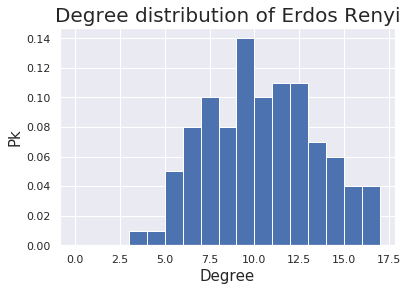

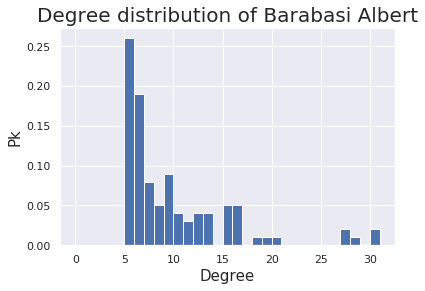

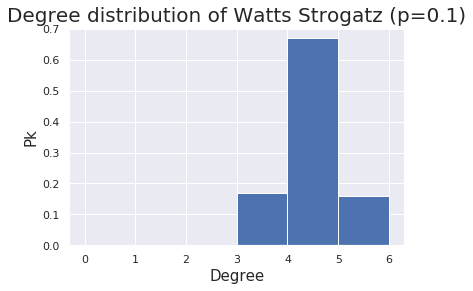

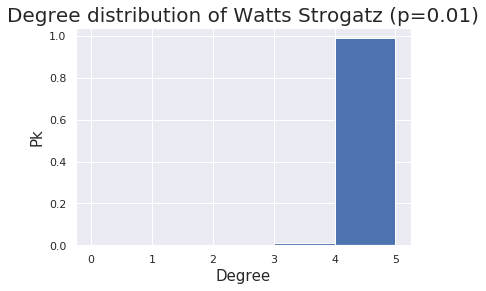

/usr/local/lib/python3.6/dist-packages/networkx/algorithms/assortativity/correlation.py:288: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)


In [67]:
results = pd.DataFrame(index=graphs.keys())

N = 100 if TESTING else 1000
REPS = 3 if TESTING else 30

for graph_name, graph_func in graphs.items():
    all_results = collections.defaultdict(list)
    # Calculate various time the different measures
    for idx in range(REPS):
        graph = graph_func(N)
        # Show the degree dist of a random member
        if idx == 0:
            degree_distribution(graph, hist=True, 
                                title=f"Degree distribution of {graph_name}")

        for name, func in all_funcs.items():
            all_results[name].append(func(graph))
    
    # Calculate mean and std of measures
    for name in all_funcs.keys():
        all_results[name] = np.array(all_results[name])
        mean = all_results[name].mean()
        std = all_results[name].std()
        results.loc[graph_name, name + " mean"] = mean
        results.loc[graph_name, name + " std"] = std

In [65]:
results.T

,Erdos Renyi,Barabasi Albert,Watts Strogatz (p=0.1),Watts Strogatz (p=0.01)
Num nodes mean,100.000000,100.000000,100.000000,100.000000
Num nodes std,0.000000,0.000000,0.000000,0.000000
Avg degree mean,9.940000,9.500000,4.000000,4.000000
Avg degree std,0.192527,0.000000,0.000000,0.000000
2nd Momentum mean,108.340000,130.146667,16.340000,16.046667
2nd Momentum std,5.288503,4.063901,0.016330,0.024944
Avg shortest path mean,2.239663,2.233131,5.157306,9.051582
Avg shortest path std,0.012047,0.019228,0.267522,0.969460
Avg clust coef mean,0.101743,0.201261,0.388333,0.483667
Avg clust coef std,0.004995,0.015906,0.004769,0.009959


# TODO: DISCUSS


---

<br>
<br>
<br>
<br>
<br>
<br>



# Q2

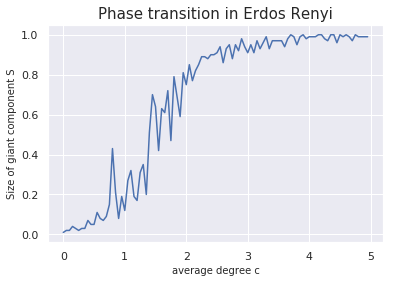

In [187]:
S = []
vk = []
for c in np.arange(0, 5, 0.05):
    p = c/(N-1)
    graph = erdos_renyi(N=N, p=p)
    connected_graph = sorted(nx.connected_component_subgraphs(graph), 
                             key=len, reverse=True)
    S.append(len(connected_graph[0])/N)
    vk.append(c)

plt.figure()
plt.plot(vk, S, 'b', label='Largest component size')
plt.xlabel("average degree c", fontsize=10)
plt.ylabel("Size of giant component S", fontsize=10)
plt.title("Phase transition in Erdos Renyi", fontsize=15)
plt.grid(True)
plt.show();

In [ ]:
#Verify the small-world property by plotting the average shortest path length 
#and diameter in terms of the number of nodes:

In [206]:
%%time
all_ns = [x for x in range(100, 1001, 100)]
all_ks = [4, 10, 20, 30]
path_lengths = collections.defaultdict(list)
diameters = collections.defaultdict(list)
temp = collections.defaultdict(list)

for k in all_ks:
    for n in all_ns:
        graph = erdos_renyi(N=n, avg_degree=k)
        path_lengths[k].append(all_funcs["Avg shortest path"](graph))
        temp[k].append(diameter(graph))
        value = np.array(list(dict(graph.degree).values())).mean()
        diameters[k].append(np.log10(n) / np.log10(value))
    if TESTING:
        break

We will use only the largest component
We will use only the largest component
We will use only the largest component
We will use only the largest component
We will use only the largest component
We will use only the largest component
We will use only the largest component
We will use only the largest component
We will use only the largest component
We will use only the largest component
We will use only the largest component
We will use only the largest component
We will use only the largest component
We will use only the largest component
We will use only the largest component
We will use only the largest component
We will use only the largest component
We will use only the largest component
We will use only the largest component
We will use only the largest component
CPU times: user 34.5 s, sys: 0 ns, total: 34.5 s
Wall time: 34.5 s


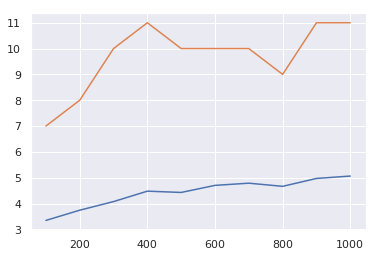

In [207]:
for k in all_ks:
    plt.plot(all_ns, diameters[k], label="small")
    plt.plot(all_ns, temp[k], label="diameter")
    break

# TODO: DISCUSS


---

<br>
<br>
<br>
<br>
<br>
<br>



# Q3

In [159]:
%%time
vcc = []
vl = []
vq = []
start = 0
for stop in [0.001, 0.01, 0.1, 1]:
    if stop == 0.001:
        continue
    for p in np.linspace(start, stop, num=10):
        graph = watts_strogatz(p=p)
        cc = nx.average_clustering(graph)
        vcc.append(cc)
        l = nx.average_shortest_path_length(graph)
        vl.append(l)
        vq.append(p)
    start = stop

CPU times: user 1.54 s, sys: 16 µs, total: 1.54 s
Wall time: 1.54 s


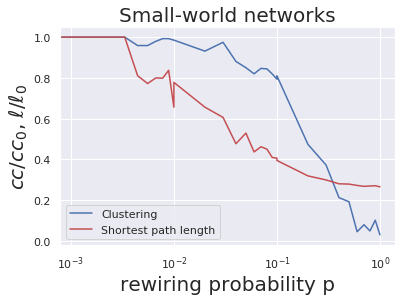

In [167]:
plt.figure()
plt.semilogx(vq, np.array(vcc)/vcc[0], 'b', label='Clustering')
plt.semilogx(vq, np.array(vl)/vl[0], 'r', label='Shortest path length')
plt.xlabel("rewiring probability p", fontsize=20)
plt.ylabel("$cc/cc_0$, $\ell/\ell_0$", fontsize=20)
plt.title("Small-world networks", fontsize=20)
plt.legend()
plt.grid(True)
plt.show();

In [178]:
%%time
lst = []
all_ps = np.linspace(0, 1, num=200)
for p in all_ps:
    graph = watts_strogatz(p=p)
    lst.append(second_moment(graph))

CPU times: user 242 ms, sys: 9 µs, total: 242 ms
Wall time: 240 ms


No handles with labels found to put in legend.


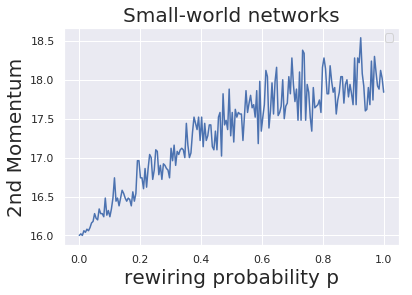

In [179]:
plt.figure()
plt.plot(all_ps, lst)
plt.xlabel("rewiring probability p", fontsize=20)
plt.ylabel("2nd Momentum", fontsize=20)
plt.title("Small-world networks", fontsize=20)
plt.legend()
plt.grid(True)
plt.show();

# TODO: DISCUSS


---

<br>
<br>
<br>
<br>
<br>
<br>



# Q4

# TODO: DISCUSS


---

<br>
<br>
<br>
<br>
<br>
<br>



# Q5

In [123]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
if not TESTING:
    assert results.isna().sum().sum() == 0
transformed = pca.fit_transform(results.fillna(0))
#pca.transform()

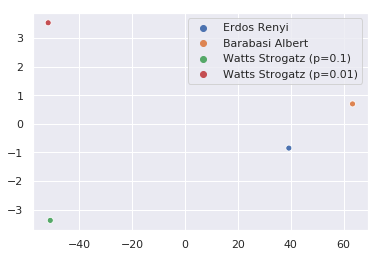

In [130]:
sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=results.index)

In [5]:
def visualize2(G, big=False):
    if big:
        plt.figure(figsize=(12, 8))
        
    labels = G.nodes()
    pos=nx.spring_layout(G)
    
    # nodes
    nx.draw_networkx_nodes(G,pos,node_size=700)

    # edges
    nx.draw_networkx_edges(G,pos,
                        width=6,alpha=0.5,edge_color='b',style='dashed')

    # labels
    nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')

    plt.axis('off')
    plt.show() # display


In [6]:
def degree_distribution(G, hist=False):
    vk = dict(G.degree())
    vk = list(vk.values())  # we get only the degree values
    vk = np.array(vk)
    maxk = np.max(vk)
    mink = np.min(vk)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    
    if hist:
        plt.hist(vk, bins=range(0, maxk+1), normed=True)
        plt.ylabel("Pk", fontsize=15)
        plt.xlabel("Degree", fontsize=15)
        plt.title("Degree distribution", fontsize=20)
        plt.grid(True)
        plt.show(True)
    
    return kvalues, Pk

In [7]:
def draw_centrality_hist(centralities, title="Defaul title", ylabel="Default ylabel", xlabel="Defaul xlabel"):
    """
    centralities = np.array(centralities)
    maxk = np.max(centralities)
    mink = np.min(centralities)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    """
    
    plt.figure(figsize=(6,4))
    #plt.hist(centralities, bins=range(0, maxk+1), normed=True)
    plt.hist(centralities, density=True)
    plt.title(title, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.show(True)

In [8]:
def acc(G):
    N = len(G.nodes)
    vk = dict(G.degree())
    vk = list(vk.values())
    A = nx.adjacency_matrix(G)
    P = np.zeros((N,N), dtype = 'float')
    for i in np.arange(0, N):
        for j in np.arange(0, N):
            if(vk[i] > 0):
                P[i,j] = A[i,j]/vk[i]
    P2 = expm(P)/np.exp(1)
    vacc = np.zeros(N, dtype = float)
    for i in np.arange(0, N):
        acc = 0
        for j in np.arange(0,N):
            if(P2[i,j] > 0):
                acc = acc + P2[i,j]*np.log(P2[i,j])
        acc = np.exp(-acc)
        vacc[i] = acc
    return vacc

In [9]:
def calc_knn(graph):
    knn = []
    for i in graph.nodes():
        aux =  nx.average_neighbor_degree(graph, nodes = [i])
        knn.append(float(aux[i]))
    return np.array(knn) 

In [10]:
def calc_knn_k(vk, knn, plot=False):
    knnk = list()
    ks = list()
    for k in np.arange(np.min(vk), np.max(vk)):
        aux = vk == k
        if(len(knn[aux]) > 0):
            av_knn = np.mean(knn[aux]) #average clustering among all the nodes with degree k
            knnk.append(av_knn)
            ks.append(k)
            
    if plot:
        plt.plot(ks, knnk, 'ro')
        #plt.loglog(ks,knnk,'bo',basex=10,basey=10)
        #plt.title("Average neighborhood connectivity vs degree")
        plt.ylabel("knn(k)")
        plt.xlabel("k")
        plt.grid(True)
        plt.savefig('knnk.eps')

        # determine best fit line
        par = np.polyfit(ks, knnk, 1, full=True)
        slope=par[0][0]
        intercept=par[0][1]
        xl = [min(ks), max(ks)]
        yl = [slope*xx + intercept  for xx in xl]
        plt.plot(xl, yl, '-b')
        plt.savefig('knn.eps') #save the figure into a file
        plt.show(True)
        
    return ks, knn

Load necessary datasets into all_graphs

In [11]:
# Read all the data we will use now and in the future
all_graphs = {}
all_graphs["E-road"] = nx.read_edgelist("data/euroroad.txt")

all_graphs["Proteins"] = nx.read_edgelist("data/out.proteins", comments="%")

all_graphs["Hamster"] = nx.read_edgelist("data/out.petster-friendships-hamster-uniq", comments="%")

all_graphs["C Elegans 2004"] = nx.read_edgelist("data/wi2004.txt", comments="#")
all_graphs["C Elegans 2007"] = nx.read_edgelist("data/wi2007.txt", comments="#")

all_graphs["US Power Grid"] = nx.read_gml("data/uspowergrid.gml", label="id")

all_graphs["C elegans"] = nx.MultiGraph()
all_graphs["C elegans"] = nx.read_gml("data/celegansneural.gml")
all_graphs["C elegans"] = nx.Graph(all_graphs["C elegans"])
all_graphs["C elegans"] = nx.convert_node_labels_to_integers(all_graphs["C elegans"], first_label=0)

all_graphs["US Airports"] = nx.Graph()
all_graphs["US Airports"] = nx.read_edgelist("data/USairport500.txt", nodetype=int, data=(('weight',float),))

# Read from csv file
df = pd.read_csv('data/rdependencies.csv')
all_graphs["R Dependencies"] = nx.from_pandas_edgelist(df, source="from", target="to", edge_attr=None)

# Cities' networks
all_graphs["Motuca"] = ox.graph_from_place('Motuca', network_type='drive', simplify=False)
all_graphs["Mombuca"] = ox.graph_from_place('Mombuca', network_type='drive', simplify=False)
all_graphs["Guatapara"] = ox.graph_from_place('Guatapara', network_type='drive', simplify=False)
all_graphs["Rincao"] = ox.graph_from_place('Rincao', network_type='drive', simplify=False)

# Convert data to undirected and remove loops
for graph in all_graphs.keys():
    all_graphs[graph] = all_graphs[graph].to_undirected()
    if graph != "R Dependencies":
          all_graphs[graph].remove_edges_from(nx.selfloop_edges(all_graphs[graph]))

# Q1

In [9]:
def q1centralities(net):
    centralities = {}
    centralities["Degree"] = list(dict(all_graphs[net].degree()).values())
    centralities["K-Core"] = list(dict(nx.core_number(all_graphs[net])).values())
    centralities["Closeness"] = list(dict(nx.closeness_centrality(all_graphs[net])).values())
    centralities["Betweenness"] = list(dict(nx.betweenness_centrality(all_graphs[net])).values())
    centralities["Eigenvector"] = list(dict(nx.eigenvector_centrality(all_graphs[net], max_iter = 1000)).values())
    centralities["Pagerank"] = list(dict(nx.pagerank(all_graphs[net], alpha=0.85)).values())
    centralities["Accessibility"] = acc(all_graphs[net])
    #centralities["Communicability"] = list(dict(nx.communicability_betweenness_centrality(all_graphs[net])).values())
        
    return centralities
        

In [10]:
def correlationMatrix(centralities):
    df = pd.DataFrame(centralities)
    corr = df.corr()
    plt.figure(figsize=(8,8))
    plt.imshow(corr, cmap='Blues', interpolation='none', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(corr)), corr.columns, rotation='vertical', fontsize=20)
    plt.yticks(range(len(corr)), corr.columns, fontsize=20);
    plt.suptitle('Correlation between centrality measures', fontsize=20)
    plt.grid(False)
    plt.show()

==================================== E-road Correlation Matrix ====================================


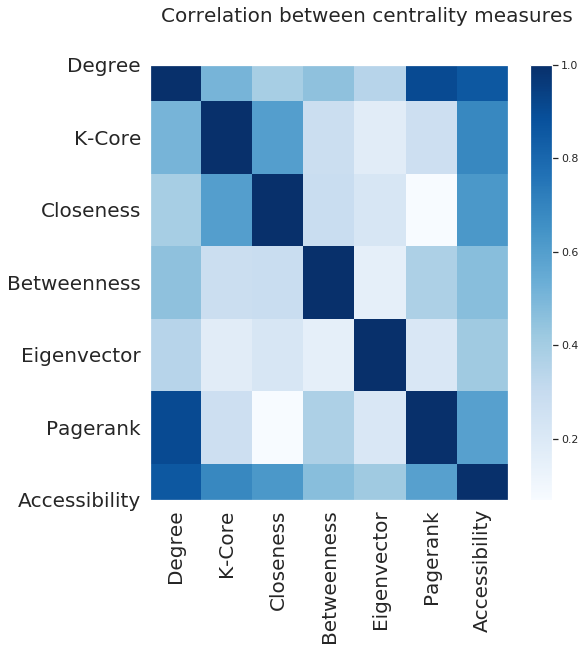

In [11]:
# q1nets = ["E-road", "Hamster", "C elegans", "US Airports"]
q1nets = ["E-road"]

for net in q1nets:
    print("==================================== " + net + " Correlation Matrix ====================================")
    correlationMatrix(q1centralities(net))

We notice that the correlations are higher between any measure and the Degree measure or any measure and the Accessibility measure. Also, it is worth noticing that Pagerank and Degree have a particular high correlation.

# Q2

## I) Motuca

### Degree

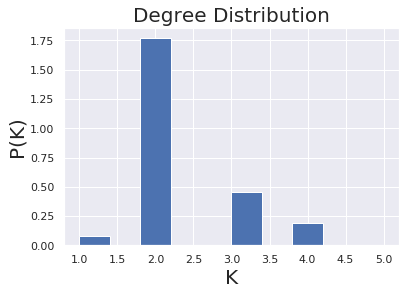

In [12]:
vk = list(dict(all_graphs["Motuca"].degree()).values())

draw_centrality_hist(vk, title="Degree Distribution", ylabel="P(K)", xlabel="K")

### Closeness Centrality

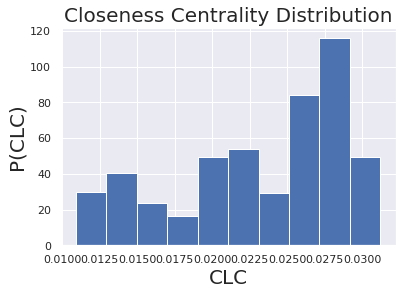

In [13]:
CLC = list(dict(nx.closeness_centrality(all_graphs["Motuca"])).values())

draw_centrality_hist(CLC, title="Closeness Centrality Distribution", ylabel="P(CLC)", xlabel="CLC")

### Betweeness Centrality

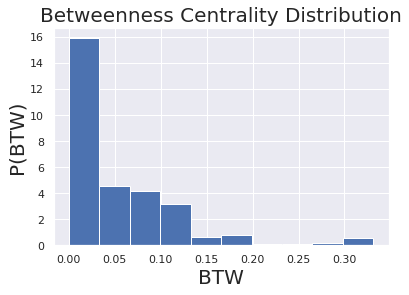

In [14]:
BTW = list(dict(nx.betweenness_centrality(all_graphs["Motuca"])).values())

draw_centrality_hist(BTW, title="Betweenness Centrality Distribution", ylabel="P(BTW)", xlabel="BTW")

## II) Mombuca

### Degree

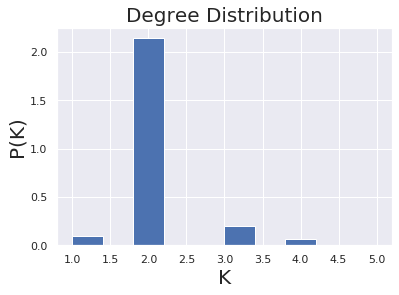

In [15]:
vk = list(dict(all_graphs["Mombuca"].degree()).values())

draw_centrality_hist(vk, title="Degree Distribution", ylabel="P(K)", xlabel="K")

### Closeness Centrality

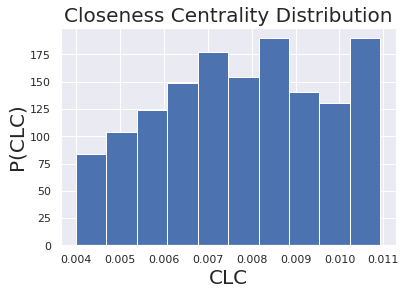

In [16]:
CLC = list(dict(nx.closeness_centrality(all_graphs["Mombuca"])).values())

draw_centrality_hist(CLC, title="Closeness Centrality Distribution", ylabel="P(CLC)", xlabel="CLC")

### Betweeness Centrality

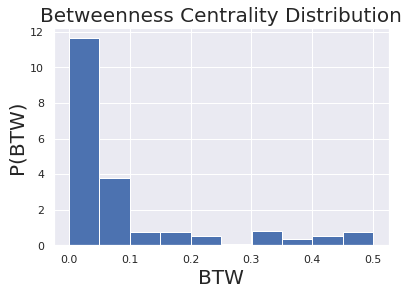

In [17]:
BTW = list(dict(nx.betweenness_centrality(all_graphs["Mombuca"])).values())

draw_centrality_hist(BTW, title="Betweenness Centrality Distribution", ylabel="P(BTW)", xlabel="BTW")

## III) Guatapara

### Degree

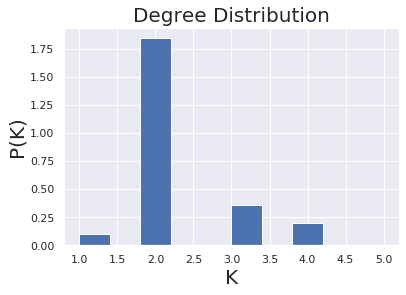

In [18]:
vk = list(dict(all_graphs["Guatapara"].degree()).values())

draw_centrality_hist(vk, title="Degree Distribution", ylabel="P(K)", xlabel="K")

### Closeness Centrality

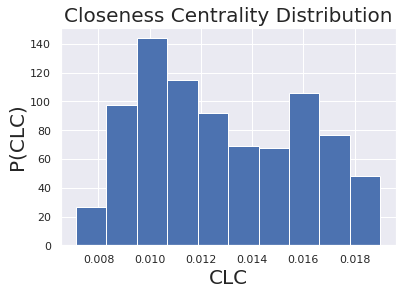

In [19]:
CLC = list(dict(nx.closeness_centrality(all_graphs["Guatapara"])).values())

draw_centrality_hist(CLC, title="Closeness Centrality Distribution", ylabel="P(CLC)", xlabel="CLC")

### Betweeness Centrality

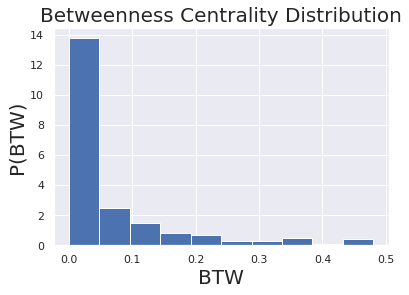

In [20]:
BTW = list(dict(nx.betweenness_centrality(all_graphs["Guatapara"])).values())

draw_centrality_hist(BTW, title="Betweenness Centrality Distribution", ylabel="P(BTW)", xlabel="BTW")

## IV) Rincão

### Degree

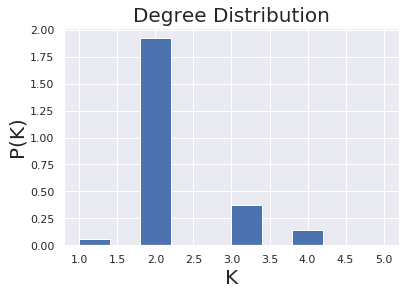

In [21]:
vk = list(dict(all_graphs["Rincao"].degree()).values())

draw_centrality_hist(vk, title="Degree Distribution", ylabel="P(K)", xlabel="K")

### Closeness Centrality

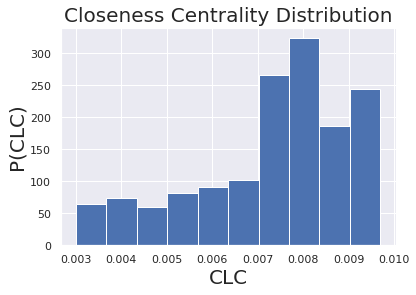

In [22]:
CLC = list(dict(nx.closeness_centrality(all_graphs["Rincao"])).values())

draw_centrality_hist(CLC, title="Closeness Centrality Distribution", ylabel="P(CLC)", xlabel="CLC")

### Betweeness Centrality

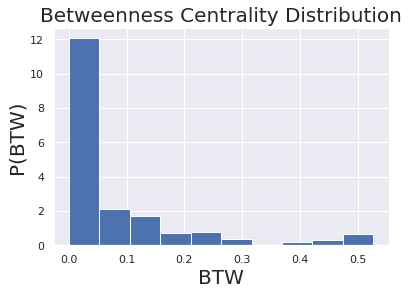

In [23]:
BTW = list(dict(nx.betweenness_centrality(all_graphs["Rincao"])).values())

draw_centrality_hist(BTW, title="Betweenness Centrality Distribution", ylabel="P(BTW)", xlabel="BTW")

We can say that Rincão is the easiest city to navigate

# Q3

In [11]:
def q3centralities(nets):
    for net in nets:
        print("=============== " + net + " ===============")
        
        degree_cent = list(dict(all_graphs[net].degree()).values())
        draw_centrality_hist(degree_cent, title="Degree Centrality Histogram", ylabel="P(K)", xlabel="K")
        
        closeness_cent = list(dict(nx.closeness_centrality(all_graphs[net])).values())
        draw_centrality_hist(closeness_cent, title="Closeness Centrality Histogram", ylabel="P(CLC)", xlabel="CLC")
        
        eigenvector_cent = list(dict(nx.eigenvector_centrality(all_graphs[net], max_iter = 1000)).values())
        draw_centrality_hist(eigenvector_cent, title="Eigenvector Centrality Histogram", ylabel="P(EC)", xlabel="EC")
        
        pagerank_cent = list(dict(nx.pagerank(all_graphs[net], alpha=0.85)).values())
        draw_centrality_hist(pagerank_cent, title="Pagerank Centrality Histogram", ylabel="P(PR)", xlabel="PR")

=============== C Elegans 2004 ===============


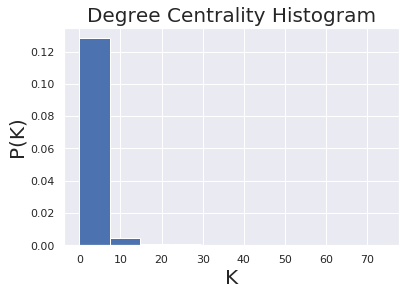

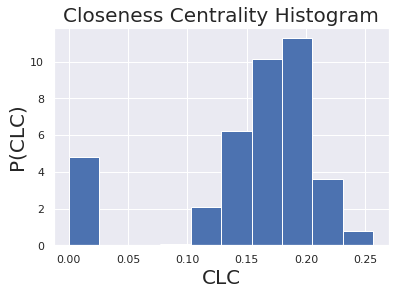

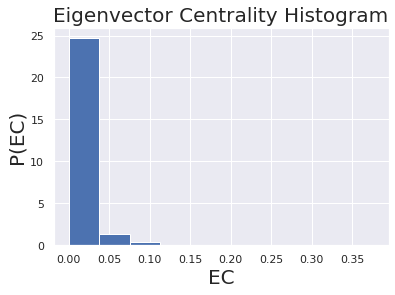

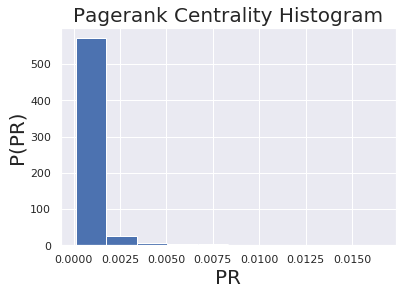

=============== C Elegans 2007 ===============


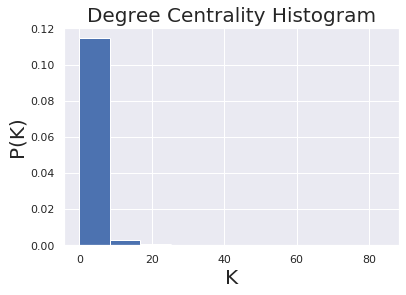

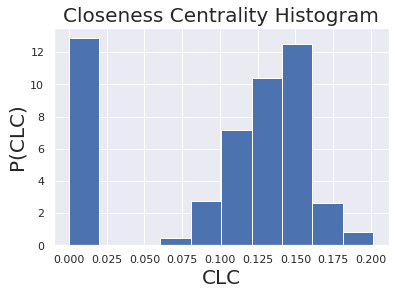

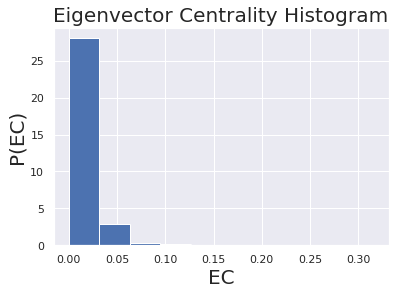

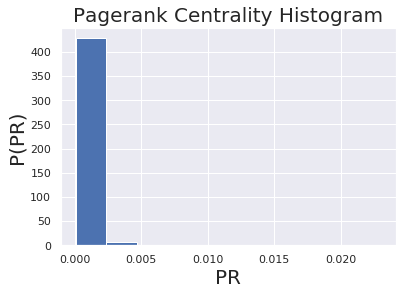

In [12]:
# q3nets = ["Proteins", "C Elegans 2004", "C Elegans 2007", "US Power Grid"]    
q3nets = ["C Elegans 2004", "C Elegans 2007"]
q3centralities(q3nets)

Looking at the C Elegans' networks we can see that all the measures are very similar, which can lead us to conclude that networks of the same type tend to have similarities relative to these measures

# Q4

In [25]:
def q4centralities(net):
    degree_cent = list(dict(all_graphs[net].degree()).values())
    kcore_cent = list(dict(nx.core_number(all_graphs[net])).values())
    closeness_cent = list(dict(nx.closeness_centrality(all_graphs[net])).values())
    betweenness_cent = list(dict(nx.betweenness_centrality(all_graphs[net])).values())
    eigenvector_cent = list(dict(nx.eigenvector_centrality(all_graphs[net], max_iter = 1000)).values())
    pagerank_cent = list(dict(nx.pagerank(all_graphs[net], alpha=0.85)).values())
    accessibility_cent = acc(all_graphs[net])
    #communicability_cent = list(dict(nx.communicability_betweenness_centrality(all_graphs[net])).values())
        
    return [degree_cent, kcore_cent, closeness_cent, betweenness_cent, eigenvector_cent, pagerank_cent,
           accessibility_cent]
        

In [47]:
def q4measures(cents, features):
    measures = []
    
    for cent in cents:
        average = np.mean(cent)
        #measures.append(average)
        
        standard_deviation = np.std(cent)
        #measures.append(standard_deviation)
        
        second_moment = scipy.stats.moment(cent, moment=2)
        #measures.append(second_moment)
        
        shannon_entropy = scipy.stats.entropy(cent)
        #measures.append(shannon_entropy)
        
        features.append([average, standard_deviation, second_moment, shannon_entropy])

In [48]:
# q4nets = ["Proteins", "C Elegans 2004", "C Elegans 2007", "US Power Grid"]
q4nets = ["C Elegans 2004", "C Elegans 2007"]

features = []
for net in q4nets:
    q4measures(q4centralities(net), features)

In [49]:
features = np.array(features)
print(features)

[[2.72594988e+00 5.15625661e+00 2.65869822e+01 6.47095086e+00]
 [1.52223120e+00 8.36050422e-01 6.98980309e-01 6.98900878e+00]
 [1.53234520e-01 6.32994970e-02 4.00682632e-03 6.97934815e+00]
 [2.59073172e-03 9.13055458e-03 8.33670269e-05 5.25826179e+00]
 [1.16394019e-02 2.59409283e-02 6.72931760e-04 5.92071675e+00]
 [8.08407437e-04 1.16742099e-03 1.36287177e-06 6.69166328e+00]
 [6.78915836e+00 3.88291764e+00 1.50770494e+01 6.97385432e+00]
 [2.29144385e+00 4.37779174e+00 1.91650605e+01 6.66581258e+00]
 [1.32152406e+00 7.16659533e-01 5.13600886e-01 7.18318380e+00]
 [9.92427644e-02 6.14269798e-02 3.77327385e-03 7.00907234e+00]
 [1.73199729e-03 6.42564507e-03 4.12889146e-05 5.21141916e+00]
 [9.92173200e-03 2.38748494e-02 5.70008432e-04 5.96622805e+00]
 [6.68449198e-04 1.00686821e-03 1.01378358e-06 6.90740529e+00]
 [5.62014595e+00 3.43145522e+00 1.17748850e+01 7.14734440e+00]]


In [50]:
pca = PCA(n_components=2, whiten=True)
pca.fit(features)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

7


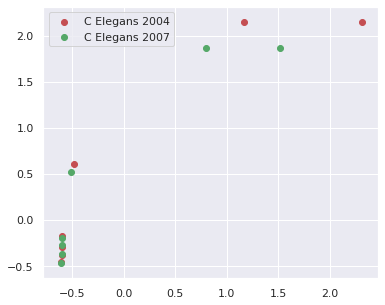

In [53]:
X_pca = pca.transform(np.array(features))
target_ids = range(2)

plt.figure(figsize=(6, 5))
    
arr_half = len(features)//2
print(arr_half)
    
plt.scatter(X_pca[0, 0], X_pca[i, 1], c='r', label="C Elegans 2004")

plt.scatter(X_pca[arr_half, 0], X_pca[arr_half+i, 1], c='g', label="C Elegans 2007")

for i in range(1, arr_half):
    plt.scatter(X_pca[i, 0], X_pca[i, 1], c='r')

    plt.scatter(X_pca[arr_half + i, 0], X_pca[arr_half+i, 1], c='g')

plt.legend()
plt.show()

# Q5

In [33]:
def q5correlations(graph):
    # First calculate knn
    knn = calc_knn(graph)
    
    # Now calculate vk
    vk = dict(graph.degree())
    vk = list(vk.values())
    
    # From knn and vk, calculate ks and knn(k)
    ks, knnk = calc_knn_k(vk, knn, plot=True) # also, plot the scatter graph
    
    # Pearson correlation coefficient
    rho = np.corrcoef(ks, knnk)[0,1]
    print('Pearson correlation coefficient:', rho)
    r = nx.degree_assortativity_coefficient(graph)
    print("Assortativity coefficient:", r)


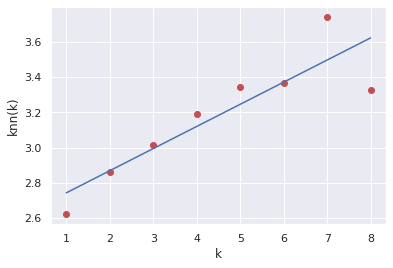

Pearson correlation coefficient: 0.2175839375
Assortativity coefficient: 0.1266835739853625


In [34]:
# q5nets = ["E-road", "C elegans", "US Airports", "Proteins"]
q5nets = ["E-road"]

for net in q5nets:
    q5correlations(all_graphs[net])

# Q6

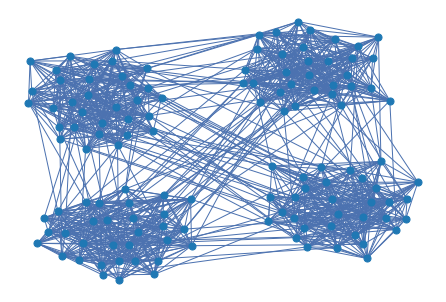

In [56]:
N = 128
tau1 = 3
tau2 = 1.5
mu = 0.04
k =16
minc = 32
maxc = 32
G = LFR_benchmark_graph(n = N, tau1 = tau1, tau2 = tau2, mu = mu, min_degree = k, 
                        max_degree = k, min_community=minc, max_community = maxc, seed = 1120)

pos=nx.spring_layout(G)
nx.draw(G, with_labels = False, nodecolor='r', edge_color='b', 
        node_size=50, font_size=16,  width=1,pos = pos)
plt.show(True)

### Girvan-Newman

In [3]:
gn_communities = community.girvan_newman(G)
k = 4
for i in np.arange(0, k-1):
    next_level_communities = next(gn_communities)
gn_communities = sorted(map(sorted, next_level_communities))
for comm in gn_communities:
    print('community:', comm)

community: [0, 5, 10, 16, 17, 20, 23, 28, 30, 31, 36, 38, 40, 42, 44, 57, 61, 65, 70, 74, 75, 79, 83, 96, 97, 102, 103, 104, 111, 124, 125, 126]
community: [1, 4, 7, 12, 13, 26, 45, 46, 47, 49, 51, 52, 54, 60, 63, 64, 67, 68, 69, 73, 80, 82, 85, 91, 93, 101, 107, 108, 109, 115, 122, 127]
community: [2, 3, 8, 14, 15, 19, 22, 24, 25, 29, 32, 33, 34, 50, 53, 59, 72, 77, 78, 81, 84, 87, 88, 89, 90, 92, 94, 100, 105, 117, 118, 120]
community: [6, 9, 11, 18, 21, 27, 35, 37, 39, 41, 43, 48, 55, 56, 58, 62, 66, 71, 76, 86, 95, 98, 99, 106, 110, 112, 113, 114, 116, 119, 121, 123]


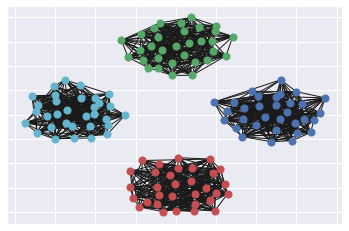

In [4]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.figure()
aux = 0
for comm in gn_communities:
    nx.draw_networkx(G.subgraph(comm), pos=pos, node_color = colors[aux], with_labels = False, node_size=50)
    aux = aux + 1
plt.show(True)

### Label Propagation

In [57]:
label_prop_comm = list(label_propagation_communities(G))
for comm in label_prop_comm:
    print(comm)

{2, 3, 8, 14, 15, 19, 22, 24, 25, 29, 32, 33, 34, 50, 53, 59, 72, 77, 78, 81, 84, 87, 88, 89, 90, 92, 94, 100, 105, 117, 118, 120}
{6, 9, 11, 18, 21, 27, 35, 37, 39, 41, 43, 48, 55, 56, 58, 62, 66, 71, 76, 86, 95, 98, 99, 106, 110, 112, 113, 114, 116, 119, 121, 123}
{1, 4, 7, 12, 13, 26, 45, 46, 47, 49, 51, 52, 54, 60, 63, 64, 67, 68, 69, 73, 80, 82, 85, 91, 93, 101, 107, 108, 109, 115, 122, 127}
{0, 5, 10, 16, 17, 20, 23, 28, 30, 31, 36, 38, 40, 42, 44, 57, 61, 65, 70, 74, 75, 79, 83, 96, 97, 102, 103, 104, 111, 124, 125, 126}


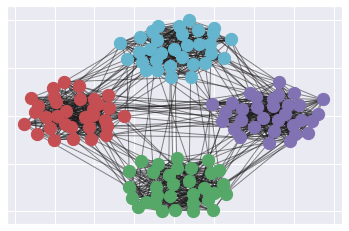

In [58]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
size = len(label_prop_comm)
count = 0.
for com in label_prop_comm :
    count = count + 1.
    list_nodes = com
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 150, node_color = colors[int(count)])
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

### Louvain

In [58]:
louv_partition = community_louvain.best_partition(G)

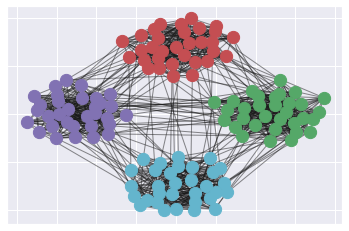

In [9]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
size = float(len(set(louv_partition.values())))
count = 0.
for com in set(louv_partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in louv_partition.keys() if louv_partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 150, node_color = colors[int(count)])
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

# Q7

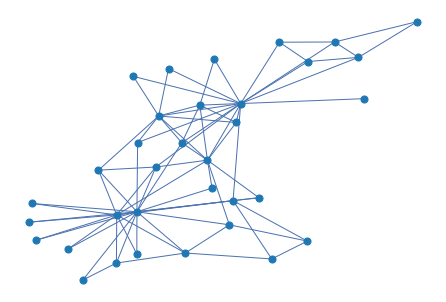

In [61]:
G = nx.read_edgelist("data/zachary.txt", nodetype=int)
G = G.to_undirected()
G = nx.convert_node_labels_to_integers(G, first_label=0)

pos=nx.spring_layout(G)
nx.draw(G, with_labels = False, nodecolor='r', edge_color='b', 
        node_size=50, font_size=16,  width=1,pos = pos)
plt.show(True)

### Girvan-Newman

In [62]:
gn_communities = community.girvan_newman(G)
k = 4
for i in np.arange(0, k-1):
    next_level_communities = next(gn_communities)
gn_communities = sorted(map(sorted, next_level_communities))
for comm in gn_communities:
    print('community:', comm)

community: [0, 1, 3, 7, 10, 11, 12, 13, 14, 15]
community: [2, 8, 16, 17, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
community: [4, 5, 6, 9, 22]
community: [18]


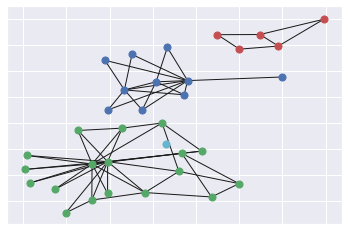

In [63]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.figure()
aux = 0
for comm in gn_communities:
    nx.draw_networkx(G.subgraph(comm), pos=pos, node_color = colors[aux], with_labels = False, node_size=50)
    aux = aux + 1
plt.show(True)

### Label Propagation

In [66]:
label_prop_comm = list(label_propagation_communities(G))
for comm in label_prop_comm:
    print(comm)

{9, 4}
{0, 1, 2, 3, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}
{5, 6, 22}


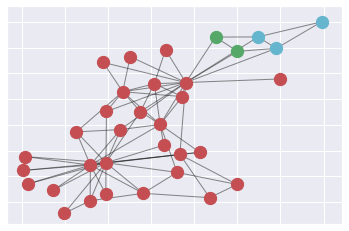

In [67]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
size = len(label_prop_comm)
count = 0.
for com in label_prop_comm :
    count = count + 1.
    list_nodes = com
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 150, node_color = colors[int(count)])
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

### Louvain

In [64]:
louv_partition = community_louvain.best_partition(G)

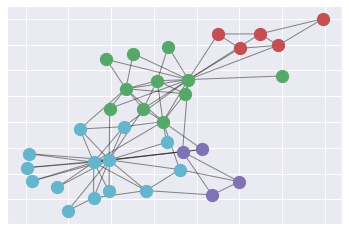

In [65]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
size = float(len(set(louv_partition.values())))
count = 0.
for com in set(louv_partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in louv_partition.keys() if louv_partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 150, node_color = colors[int(count)])
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

# Q8

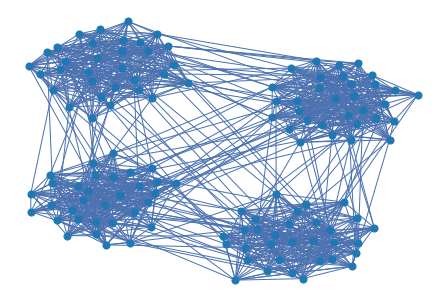

In [68]:
N = 128
tau1 = 3
tau2 = 1.5
mu = 0.04
k =16
minc = 32
maxc = 32
G = LFR_benchmark_graph(n = N, tau1 = tau1, tau2 = tau2, mu = mu, min_degree = k, 
                        max_degree = k, min_community=minc, max_community = maxc, seed = 1120)

pos=nx.spring_layout(G)
nx.draw(G, with_labels = False, nodecolor='r', edge_color='b', 
        node_size=50, font_size=16,  width=1,pos = pos)
plt.show(True)

### Girvan-Newman

In [69]:
gn_communities = community.girvan_newman(G)
k = 4
for i in np.arange(0, k-1):
    next_level_communities = next(gn_communities)
gn_communities = sorted(map(sorted, next_level_communities))
for comm in gn_communities:
    print('community:', comm)

community: [0, 5, 10, 16, 17, 20, 23, 28, 30, 31, 36, 38, 40, 42, 44, 57, 61, 65, 70, 74, 75, 79, 83, 96, 97, 102, 103, 104, 111, 124, 125, 126]
community: [1, 4, 7, 12, 13, 26, 45, 46, 47, 49, 51, 52, 54, 60, 63, 64, 67, 68, 69, 73, 80, 82, 85, 91, 93, 101, 107, 108, 109, 115, 122, 127]
community: [2, 3, 8, 14, 15, 19, 22, 24, 25, 29, 32, 33, 34, 50, 53, 59, 72, 77, 78, 81, 84, 87, 88, 89, 90, 92, 94, 100, 105, 117, 118, 120]
community: [6, 9, 11, 18, 21, 27, 35, 37, 39, 41, 43, 48, 55, 56, 58, 62, 66, 71, 76, 86, 95, 98, 99, 106, 110, 112, 113, 114, 116, 119, 121, 123]


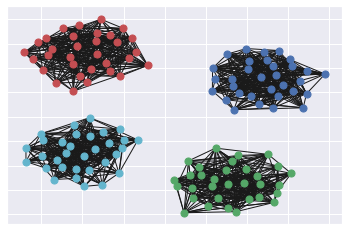

In [70]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.figure()
aux = 0
for comm in gn_communities:
    nx.draw_networkx(G.subgraph(comm), pos=pos, node_color = colors[aux], with_labels = False, node_size=50)
    aux = aux + 1
plt.show(True)

### Label Propagation

In [71]:
label_prop_comm = list(label_propagation_communities(G))
for comm in label_prop_comm:
    print(comm)

{2, 3, 8, 14, 15, 19, 22, 24, 25, 29, 32, 33, 34, 50, 53, 59, 72, 77, 78, 81, 84, 87, 88, 89, 90, 92, 94, 100, 105, 117, 118, 120}
{6, 9, 11, 18, 21, 27, 35, 37, 39, 41, 43, 48, 55, 56, 58, 62, 66, 71, 76, 86, 95, 98, 99, 106, 110, 112, 113, 114, 116, 119, 121, 123}
{1, 4, 7, 12, 13, 26, 45, 46, 47, 49, 51, 52, 54, 60, 63, 64, 67, 68, 69, 73, 80, 82, 85, 91, 93, 101, 107, 108, 109, 115, 122, 127}
{0, 5, 10, 16, 17, 20, 23, 28, 30, 31, 36, 38, 40, 42, 44, 57, 61, 65, 70, 74, 75, 79, 83, 96, 97, 102, 103, 104, 111, 124, 125, 126}


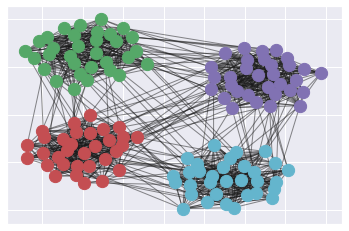

In [72]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
size = len(label_prop_comm)
count = 0.
for com in label_prop_comm :
    count = count + 1.
    list_nodes = com
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 150, node_color = colors[int(count)])
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

### Louvain

In [73]:
louv_partition = community_louvain.best_partition(G)

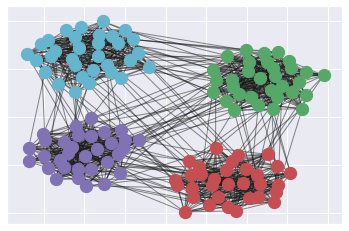

In [74]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
size = float(len(set(louv_partition.values())))
count = 0.
for com in set(louv_partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in louv_partition.keys() if louv_partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 150, node_color = colors[int(count)])
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

# Q9

In [92]:
def q9properties(net):
    properties = {}
    
    properties["N"] = len(net.nodes)
    properties["av_degree"] = np.mean(np.array(list(dict(net.degree()).values())))
    properties["assortativity"] = nx.degree_assortativity_coefficient(net)
    properties["av_shortest_path_length"] = nx.average_shortest_path_length(net)

    # Modularity
    properties["louv_partition"] = community_louvain.best_partition(G)
    properties["label_prop_comm"] = np.array(list(label_propagation_communities(G)))
    properties["gn_communities"] = community.girvan_newman(G)
    
    return properties

In [102]:
def print_louv_partition(comm):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    size = float(len(set(comm.values())))
    count = 0.
    for com in set(comm.values()) :
        count = count + 1.
        list_nodes = [nodes for nodes in comm.keys() if comm[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 150, node_color = colors[int(count)])
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.show()

In [107]:
def print_label_prop_comm(comm):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    size = len(label_prop_comm)
    count = 0.
    for com in label_prop_comm :
        count = count + 1.
        list_nodes = com
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 150, node_color = colors[int(count)])
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.show()

In [105]:
def print_gn_communities(comm):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    plt.figure()
    aux = 0
    for comm in gn_communities:
        nx.draw_networkx(G.subgraph(comm), pos=pos, node_color = colors[aux], with_labels = False, node_size=50)
        aux = aux + 1
    plt.show(True)

========== C elegans ==========
N 297
av_degree 14.464646464646465
assortativity -0.16319921031570409
av_shortest_path_length 2.455318955318955
louv_partition {0: 0, 1: 1, 2: 2, 3: 2, 4: 1, 5: 0, 6: 3, 7: 1, 8: 2, 9: 3, 10: 0, 11: 3, 12: 1, 13: 1, 14: 2, 15: 2, 16: 0, 17: 0, 18: 3, 19: 2, 20: 0, 21: 3, 22: 2, 23: 0, 24: 2, 25: 2, 26: 1, 27: 3, 28: 0, 29: 2, 30: 0, 31: 0, 32: 2, 33: 2, 34: 2, 35: 3, 36: 0, 37: 3, 38: 0, 39: 3, 40: 0, 41: 3, 42: 0, 43: 3, 44: 0, 45: 1, 46: 1, 47: 1, 48: 3, 49: 1, 50: 2, 51: 1, 52: 1, 53: 2, 54: 1, 55: 3, 56: 3, 57: 0, 58: 3, 59: 2, 60: 1, 61: 0, 62: 3, 63: 1, 64: 1, 65: 0, 66: 3, 67: 1, 68: 1, 69: 1, 70: 0, 71: 3, 72: 2, 73: 1, 74: 0, 75: 0, 76: 3, 77: 2, 78: 2, 79: 0, 80: 1, 81: 2, 82: 1, 83: 0, 84: 2, 85: 1, 86: 3, 87: 2, 88: 2, 89: 2, 90: 2, 91: 1, 92: 2, 93: 1, 94: 2, 95: 3, 96: 0, 97: 0, 98: 3, 99: 3, 100: 2, 101: 1, 102: 0, 103: 0, 104: 0, 105: 2, 106: 3, 107: 1, 108: 1, 109: 1, 110: 3, 111: 0, 112: 3, 113: 3, 114: 3, 115: 1, 116: 3, 117: 2, 118: 2

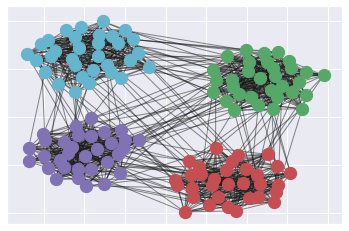

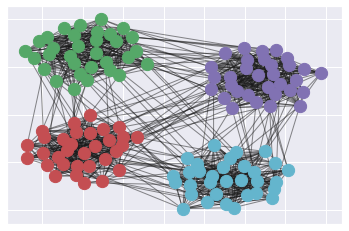

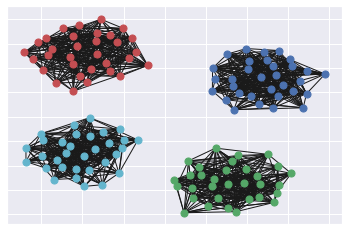

In [108]:
# q9nets = ["E-road", "C elegans", "US Airports", "Proteins"]
q9nets = ["C elegans"]

for net in q9nets:
    print("========== " + net + " ==========")
    properties = q9properties(all_graphs[net])
    for prop in properties:
        print(prop, properties[prop])
    print_louv_partition(properties["louv_partition"])
    print_label_prop_comm(properties["label_prop_comm"])
    print_gn_communities(properties["gn_communities"])
    